# Homework 7

## ASTR 5900, Fall 2017, University of Oklahoma

### Exploratory Data Analysis and KMean Analysis

# Problem 1

### Part A

Load the Old Faithful data from http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat.  

A standard procedure in problems with multi-dimensional data is to standardize the data, or give each dimension the same scaling.  It is common to make every parameter distributed around 0 with a standard variance.  That is, find a new data set with parameters $y_{i}^{(j)}$ where:

$$ y_{i}^{(j)} = \frac{x_{i}^{(j)} - \mu^{(j)}}{\sigma^{(j)}}$$

Here $x_{i}^{(j)}$ is the $i$th data point in the $j$th dimension.

Transform the Old Faithful Data in this manner.

# Some of this code might be a litte sloppy, spending too much time on it 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import random
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
import time
from sklearn.neighbors.kde import KernelDensity
import scipy.ndimage as ndimage
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from matplotlib.colors import LogNorm
import multiprocessing as mp

#The amount of processors in the computer.
N_processors = mp.cpu_count() -1
#We want to use a maximum of 10 processors.
if N_processors > 10:
    N_processors = 9

print("Num cores: {}".format(N_processors))

Num cores: 7


In [2]:
def stand_multidim(data,ndim): # input astropy table and column headers in nums as array
    
    def values(data,dim):
        sigma = np.std(data[:,dim])
        mean = np.average(data[:,dim])
        return mean,sigma
    
    for i in ndim:
        mean,sigma = values(data,i)
        for a,b in enumerate(data):
            data[a,i] = ((b[i]-mean)/sigma)
    return data[:,ndim[0]:ndim[len(ndim)-1]+1]

def chi2(science,model,std_science):
    if type(std_science) is not list:
        std_science = [std_science for x in science]
    return -0.5*(np.sum(((science-model)/std_science)**2))

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2./sigma**2)

def bimodalconstant(x,mu1,sigma1,A1,mu2,sigma2,A2,A3):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2) + A3

def constant(x,a):
    return a + x

In [3]:
file = 'old-faithful.dat'
while True:
    try:
        raw = np.loadtxt(file)
        break
    except ValueError:
        os.system("sed -i '1d' " + file)
        continue
newheader=np.array(['Eruptions','Waiting'])

In [4]:
print(raw.shape[0])
print(type(raw))

272
<type 'numpy.ndarray'>


In [5]:
newraw = stand_multidim(raw,[1,2])
#print(newraw)

### Part B

Use `sklearn.cluster.KMeans` to split the Old Faithful data into 2 clusters.  Plot the data with each point colored according to its cluster label.  Also plot the centers of the clusters by making it distinguishable from the data.

Read more at http://scikit-learn.org/stable/modules/density.html.  Consider looking at the examples on the `scikit-learn` website and the lecture.

In [6]:
temp = np.array([newraw[0],newraw[1]])
print temp


[[ 0.09849886  0.59712344]
 [-1.48145856 -1.24518118]]


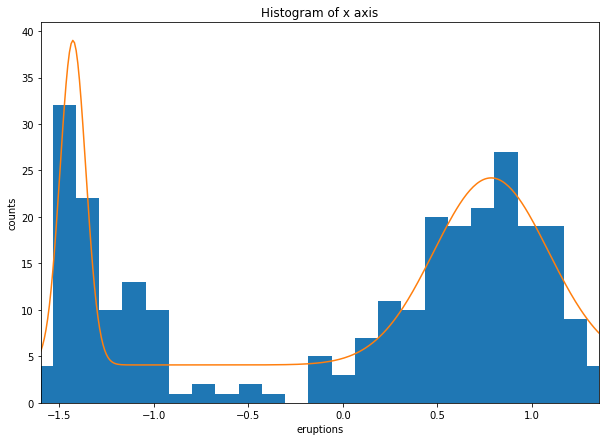

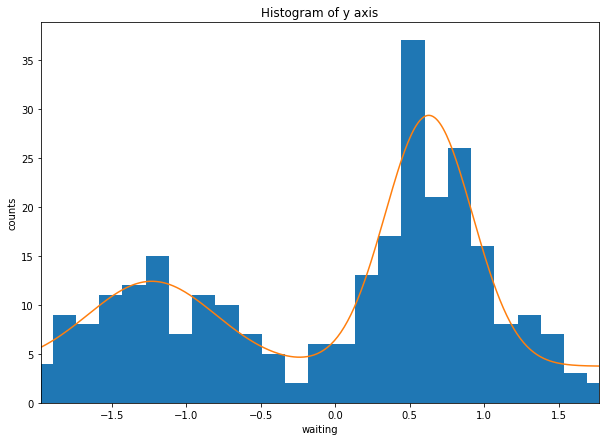

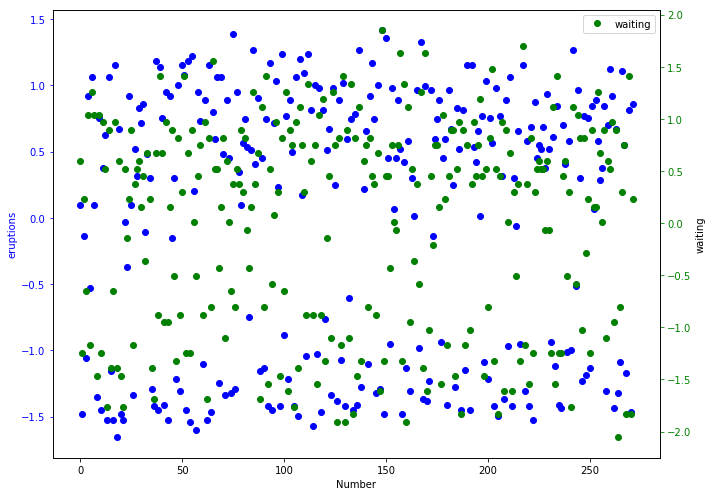

In [7]:
# eruptions waiting
newheader = ['eruptions','waiting']

plt.clf()
plt.figure(figsize=[10,7])
plt.title('Histogram of x axis')
counts,bins,ignore = plt.hist(newraw[:,0],bins=25)
mbins = 0.5*(bins[1:] + bins[:-1])
expected = np.array([-1.,1.,10.,1.,1.,10.,0])
params,cov = curve_fit(bimodalconstant,mbins,counts,expected)
xrange = max(mbins)-min(mbins) 
x = np.linspace(min(mbins)-xrange,max(mbins)+xrange,1000)
lin1 = plt.plot(x,bimodalconstant(x,*params))
plt.xlim(min(mbins),max(mbins))
plt.xlabel(newheader[0])
plt.ylabel('counts')
plt.show()

plt.clf()
plt.figure(figsize=[10,7])
plt.title('Histogram of y axis')
counts,bins,ignore = plt.hist(newraw[:,1],bins=25)
mbins = 0.5*(bins[1:] + bins[:-1])
expected = np.array([1.,1.,10.,0.,1.,10.,0])
params,cov = curve_fit(bimodalconstant,mbins,counts,expected)
xrange = max(mbins)-min(mbins) 
x = np.linspace(min(mbins)-xrange,max(mbins)+xrange,1000)
lin1 = plt.plot(x,bimodalconstant(x,*params))
plt.xlim(min(mbins),max(mbins))
plt.xlabel(newheader[1])
plt.ylabel('counts')
plt.show()

plt.clf()
fig, ax1 = plt.subplots(figsize=[10,7])
ax1.plot(range(len(newraw)),newraw[:,0],'bo',label=newheader[0])
ax1.set_xlabel('Number')
ax1.set_ylabel(newheader[0], color='blue')
ax1.tick_params('y', colors='blue')
ax2 = ax1.twinx()
ax2.plot(range(len(newraw)),newraw[:,1],'go',label=newheader[1])
ax2.set_ylabel(newheader[1], color='black')
ax2.tick_params('y', colors='g')
plt.legend()
fig.tight_layout()
plt.show()

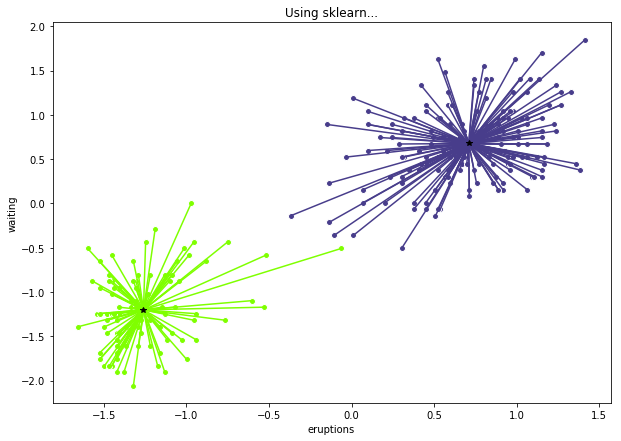

Time of sklearnrun: 0.512477874756s


In [8]:
plt.figure(figsize=(10,7))

time1 = time.time()
n_clusters = 2

k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
k_means.fit(newraw)

k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis=0)
k_means_labels = pairwise_distances_argmin(newraw, k_means_cluster_centers)

plt.xlabel(newheader[0])
plt.ylabel(newheader[1])
plt.title("Using sklearn...")
# KMeans
for k in range(n_clusters):
    x = random.choice(range(len(colors.cnames)))
    colour = [j for i,j in enumerate(colors.cnames) if i==x][0]
    
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(newraw[my_members, 0], newraw[my_members, 1], 'w',
            markerfacecolor=colour, marker='o')
    for i in newraw[my_members,:]:
        plt.plot((i[0],cluster_center[0]),(i[1],cluster_center[1]),color=colour)
    plt.plot(cluster_center[0], cluster_center[1], '*', color="black")
plt.show()
time2 = time.time()
sklearntime = time2-time1
print("Time of sklearnrun: {}s".format(sklearntime))

### Part C

Code from scratch (that is, with default python and numpy) your own k-means clustering algorithm to split the data into 2 clusters.  Refer to the lecture and Figure 9.1 in Bishop.  Plot the end result as you did in Part B.

In [9]:
# evaluating the center of the cluster from cpoints
def evalcen(mu, c):
    keys = sorted(c.keys()) # keys from dict
    temp = [] 
    for i in keys:
        temp.append(np.mean(c[i], axis = 0))
    return temp # returns list of means

# determining the convergance of cluster function
# returns true if all sets are determined
# compares two sets of mu
def finalized(mu, mu_old):
    return (set([tuple(x) for x in mu]) == set([tuple(x) for x in mu_old]))
 
# defining the cluster points
# constructs dictionary{kcluster: points}'
# input data list and mean
# output the dict
def cpoints(data, mu):
    clusters  = {}
    for x in data:
        mu_key=0
        temp = []
        for i,j in enumerate(mu):
            temp.append(((i, np.linalg.norm(x-mu[i]))))
        mu_key = min(temp, key=lambda t:t[1])[0]
        try:
            clusters[mu_key].append(x)
        except KeyError or ValueError:
            clusters[mu_key] = [x]            
    return clusters

# main function for finding k centers from x data
# needs to be generalized for allowing iterations
# returns np.array(2,clusternum) and dictionary of clusters
def locatecenters(data, Knum=2,iterations=1):
    starting = random.sample(data, Knum)
    new = random.sample(data, Knum)
    while not finalized(new, starting):
        try:
            starting=new
            clusters = cpoints(data, new)
            new = evalcen(starting, clusters)
        except ValueError:
            print('Failed iterations')
    return(new, clusters)

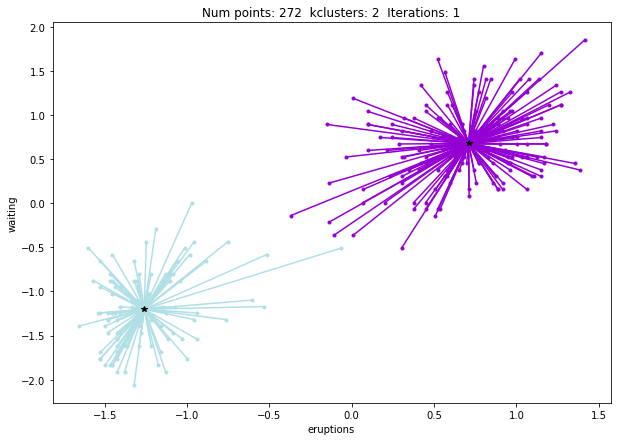

Time of Numpy run: 0.63433098793s


In [10]:
time1=time.time()
kclusters = 2
centers = locatecenters(raw[:,1:3],kclusters)
#print centers[0]

centers = locatecenters(raw[:,1:3],kclusters)

# There is an intelligent way do numerous interations but cant figure it out right now
# best way is to add a new function that allows iterations and then call the reevaluate centers after moving the mu a little bit
# now that I think about it a little more, defining a class for this kmeans would be most efficient.
plt.clf()
plt.figure(figsize=[10,7])
plt.xlabel(newheader[0])
plt.ylabel(newheader[1])
plt.title("Using numpy...")

plt.title("Num points: {}  kclusters: {}  Iterations: {}".format(raw.shape[0],kclusters,1))
for a in range(kclusters):
    x = random.choice(range(len(colors.cnames)))
    colour = [j for i,j in enumerate(colors.cnames) if i==x][0]
    plt.scatter(np.array(centers[1][a])[:,0],np.array(centers[1][a])[:,1],marker='.',color=colour)
    for j,i in enumerate(np.array(centers[1][a])[:,0]):
        plt.plot((i,np.array(centers[0][a])[0]),(np.array(centers[1][a])[j,1],np.array(centers[0][a])[1]),color=colour)
    plt.plot(np.array(centers[0][a])[0],np.array(centers[0][a])[1],color='black',marker='*')
plt.show()
#print("Centers: {}".format(centers[0]))
time2=time.time()
numpytime = time2-time1
print("Time of Numpy run: {}s".format(numpytime))

In [11]:
print("Comparing the two times: sklearn {0:.5}s vs numpy {1:.5}s = {2:.5}s".format(sklearntime,numpytime,sklearntime-numpytime))
print("Comparing the means: sklearn \n {}".format(k_means_cluster_centers))
print("vs")
print("Comparing the means: numpy \n {}".format(np.array(centers[0])))

Comparing the two times: sklearn 0.51248s vs numpy 0.63433s = -0.12185s
Comparing the means: sklearn 
 [[-1.26008539 -1.20156744]
 [ 0.70970327  0.67674488]]
vs
Comparing the means: numpy 
 [[ 0.70970327  0.67674488]
 [-1.26008539 -1.20156744]]


# Problem 2

In this problem you will perform kernel density estimation to produce
an optimal representation of the Chandra X-ray observatory data from
NGC 4636.  The X-ray emission traces the emission of hot gas in the galaxy.
The data consist of a list of the positions of individual
photons on the detector in sky coordinates.

### Part A

Load the data of NGC 4636 from `ngc4636.dat`.

Create a plot showing the individual photon points using `matplotlib.pyplot`.

Plot a histogram of the data.  Experiment with the binsize and plot representation until you obtain a pleasing image of the galaxy.  Do you see any structure in the image
besides the central concentration of hot gas?  Explain.

Perform KDE data using `sklearn.neighbors.kde.KernelDensity`.  Experiment with the 
band width and kernel until you obtain a pleasing image of the galaxy.  Do you see any 
structure in the image besides the central concentration of hot gas?  Explain.
Note that KernelDensity.score_samples returns the log of the distribution.
Also note that it may help for plotting the image to sample the distribution on a grid;
refer to the example shown in class.

In [12]:
file = 'ngc4636.dat'
while True:
    try:
        ngcraw = np.loadtxt(file)
        break
    except ValueError:
        os.system("sed -i '1d' " + file)
        continue

In [13]:
print(ngcraw.shape)

(6051, 2)


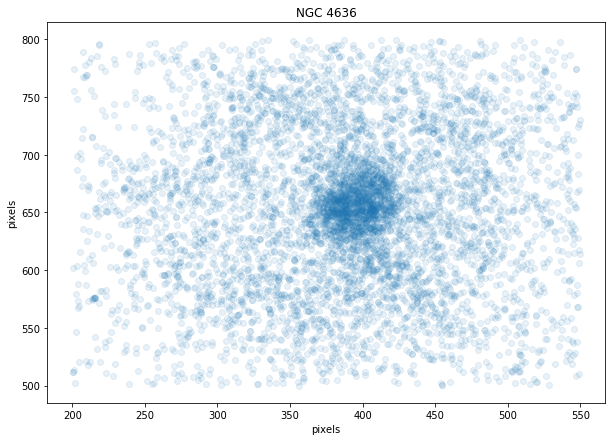

In [14]:
plt.clf()
plt.figure(figsize=[10,7])
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.title('NGC 4636')
plt.plot(ngcraw[:,0],ngcraw[:,1],'o',alpha=0.1)
plt.show()

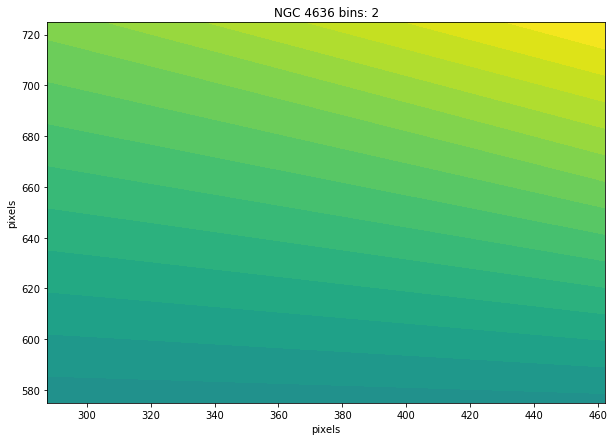

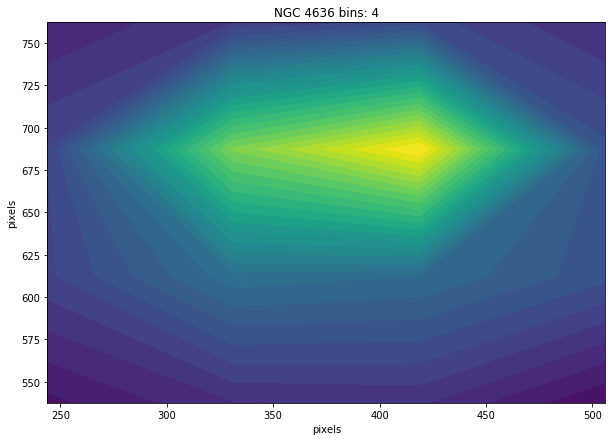

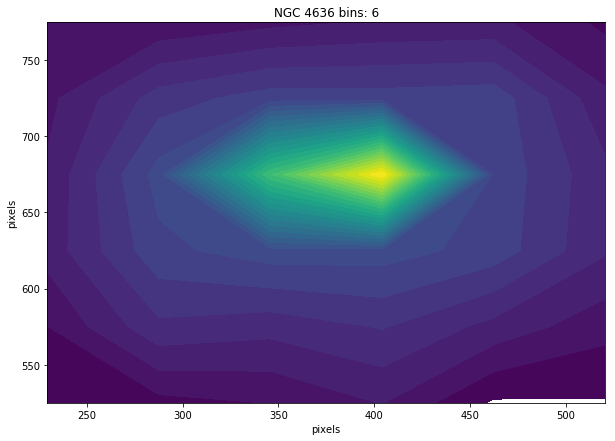

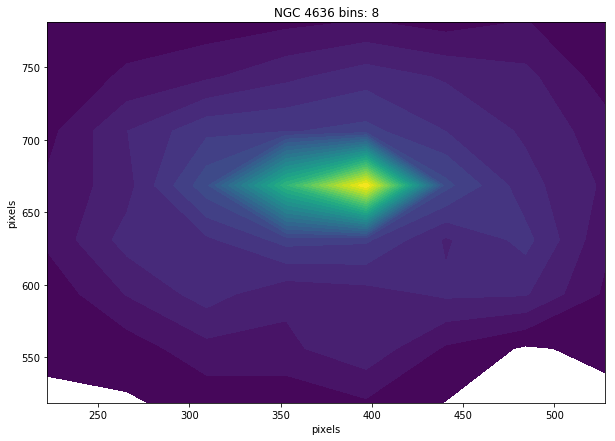

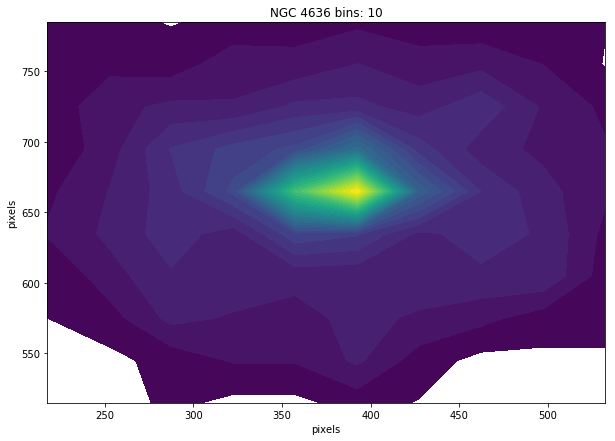

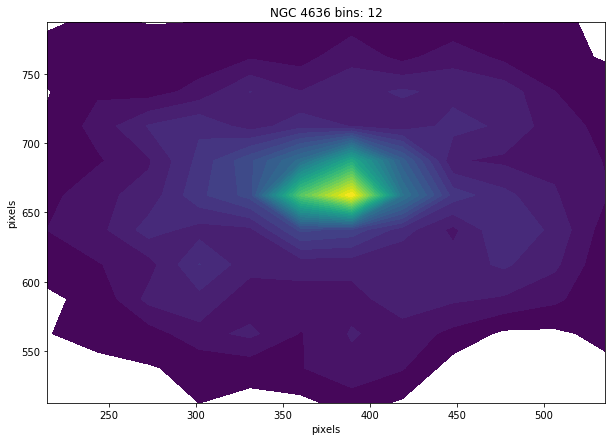

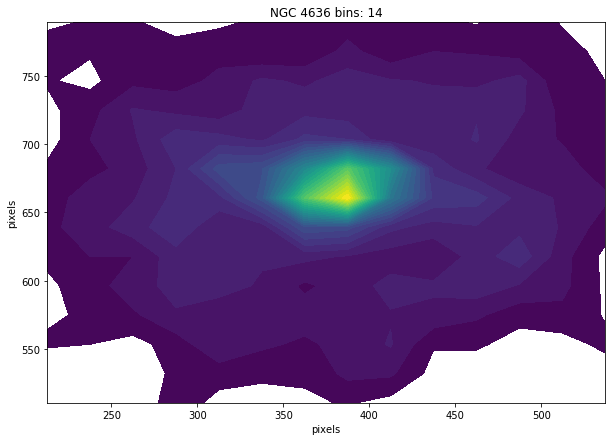

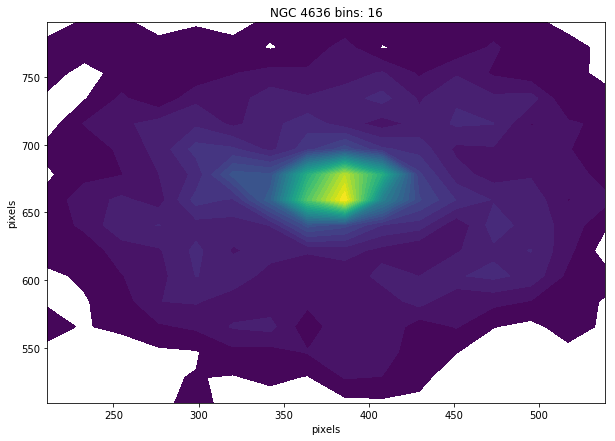

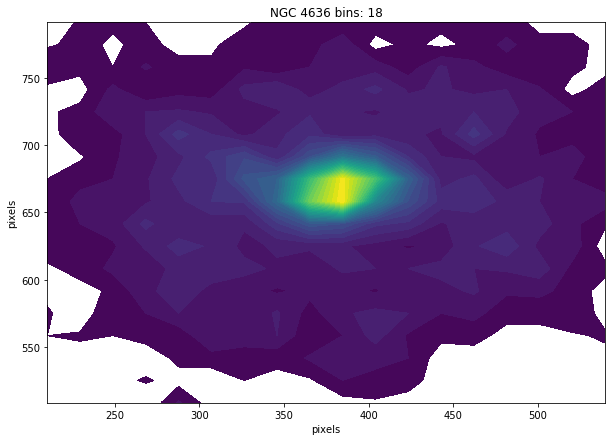

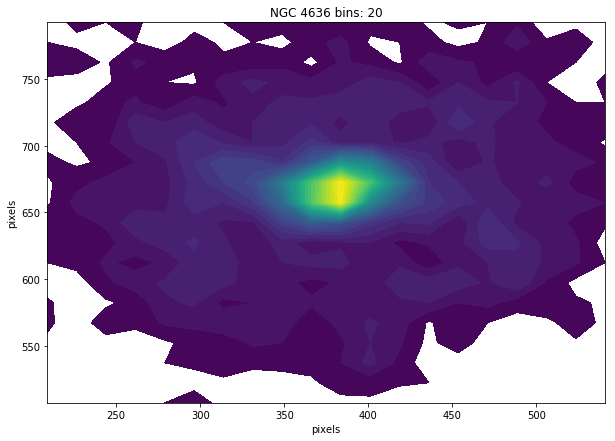

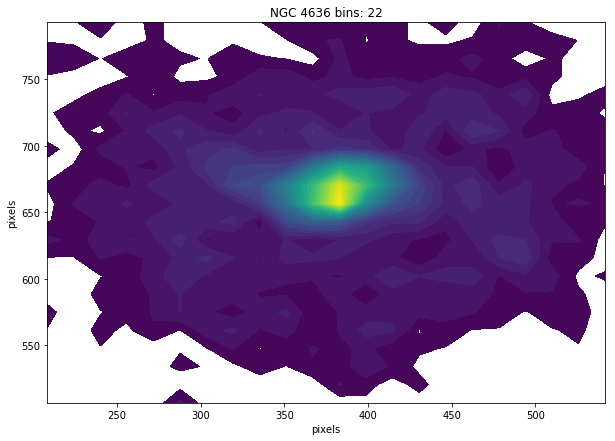

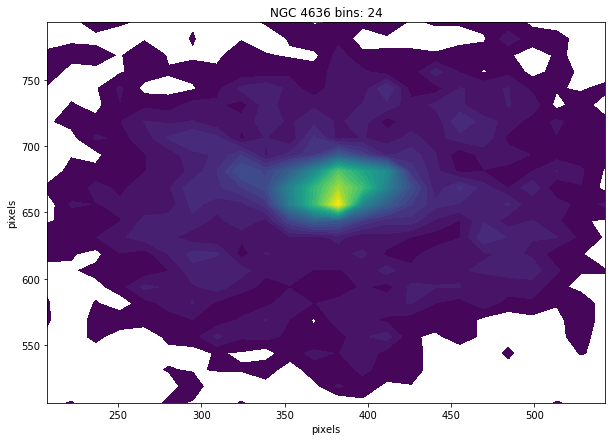

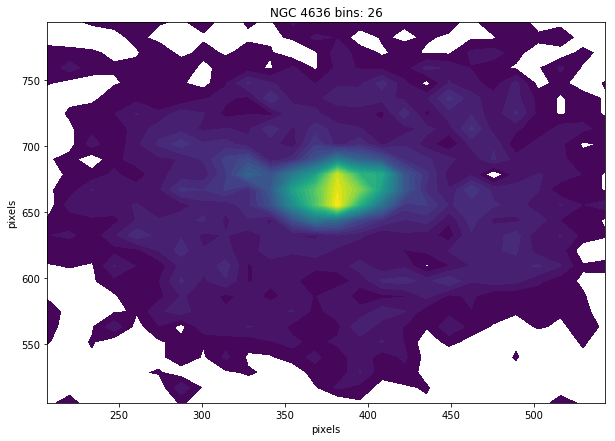

In [15]:
percent_regions=[1.0-0.9973,1.0-0.9545,1.0-0.6827,0.5,0.6827,0.9545,0.9973]
ndim=2

confidence_regions_params=np.zeros([7,ndim])

numsamples=len(ngcraw)
for i in np.arange(ndim):
    temp=ngcraw[:,i]
    x2=np.sort(temp)
    f2=np.array(range(numsamples))/float(numsamples)
    confidence_regions_params[0:7,i]=np.interp(percent_regions,f2,x2)

def PlotDensity(density, pos1out, pos2out):
    delta=density.max()/30.0
    levels=delta+delta*np.arange(30)
    plt.contourf(pos1out,pos2out,density,levels)

def MakeContour(samples, index1, index2, numbins):
     numout=len(samples)
     comp1=samples[0:numout,index1]
     comp2=samples[0:numout,index2]
     binsize1=(comp1.max()-comp1.min())/numbins
     binsize2=(comp2.max()-comp2.min())/numbins
     density=np.zeros([numbins,numbins])
     pos1=(comp1-comp1.min())/binsize1
     pos2=(comp2-comp2.min())/binsize2
     pos1out=comp1.min()+0.5*binsize1+binsize1*np.arange(numbins)
     pos2out=comp2.min()+0.5*binsize2+binsize2*np.arange(numbins)
     for i in range(numout):
        if (long(pos1[i])) < numbins and (long(pos2[i])) < numbins:
            density[long(pos1[i]),long(pos2[i])]=density[long(pos1[i]),long(pos2[i])]+1.0
     return density, pos1out, pos2out


for a in range(0,27):
    if (a%2 == 0) and (a != 0):
        plt.clf()
        plt.figure(figsize=[10,7])
        plt.xlabel('pixels')
        plt.ylabel('pixels')
        plt.title('NGC 4636 bins: {}'.format(a))
        numbins = a
        density, pos1out, pos2out=MakeContour(ngcraw,0,1,numbins)
        PlotDensity(density,pos1out,pos2out)
        plt.show()


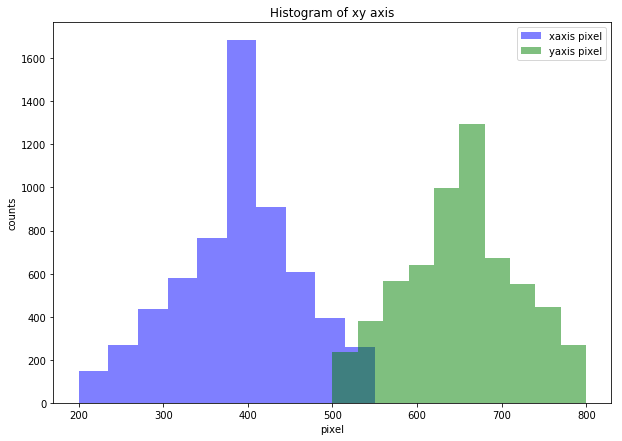

In [16]:
plt.clf()
plt.figure(figsize=[10,7])
plt.title('Histogram of xy axis')
numbins = 24
xcounts,xbins,xignore = plt.hist(ngcraw[:,0],color='blue',alpha=0.5,label='xaxis pixel')
ycounts,ybins,yignore = plt.hist(ngcraw[:,1],color='green',alpha=0.5,label='yaxis pixel')
mbins = 0.5*(min(xbins[:]) + max(ybins[:]))
plt.xlabel('pixel')
plt.ylabel('counts')
plt.legend()
plt.show()

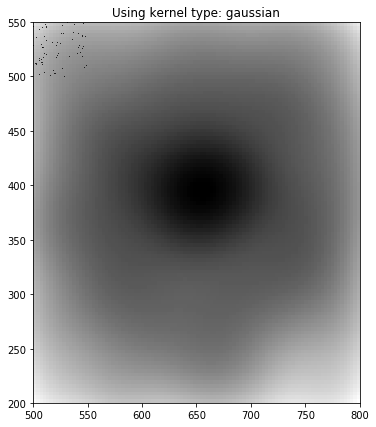

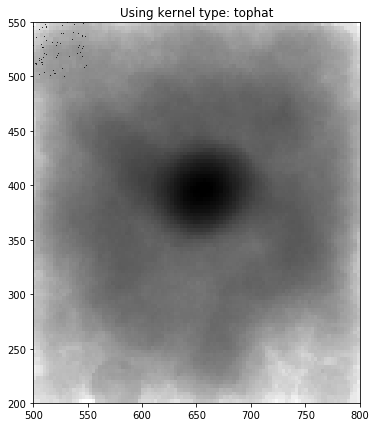

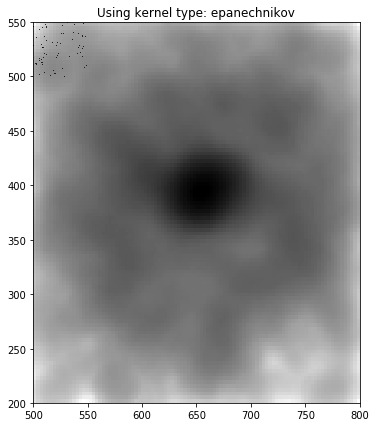

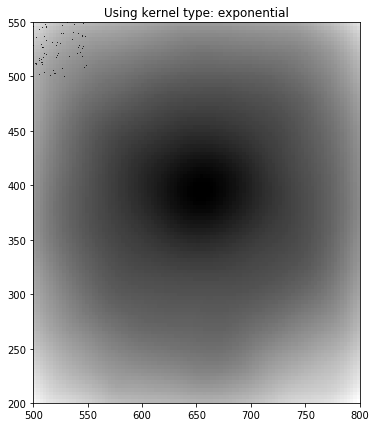

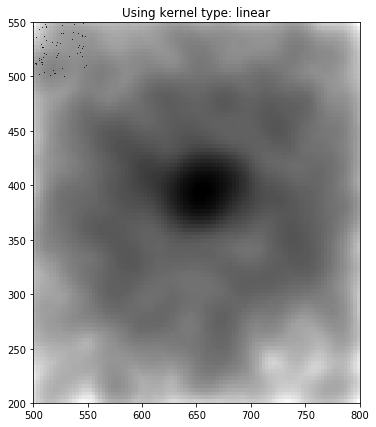

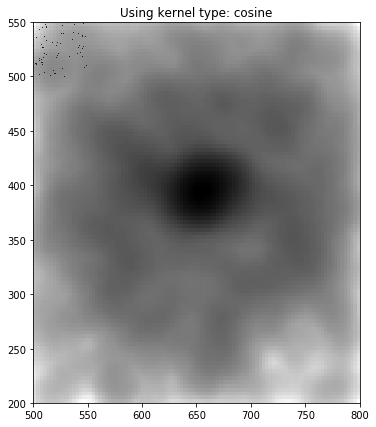

In [17]:
bw = 24
kerneltype = ['gaussian', 'tophat', 'epanechnikov','exponential', 'linear', 'cosine']

N = 100
xmin, xmax = (min(ngcraw[:,0]),max(ngcraw[:,0]))
ymin, ymax = (min(ngcraw[:,1]),max(ngcraw[:,1]))

#------------------------------------------------------------
# Evaluate for several models
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, N), np.linspace(ymin, ymax, N)))).T
for kernal in kerneltype:
    kde1 = KernelDensity(bandwidth=bw, kernel=kernal)
    log_dens1 = kde1.fit(ngcraw).score_samples(Xgrid)
    dens1 = ngcraw.shape[0] * np.exp(log_dens1).reshape((N,N))
    plt.clf()
    plt.figure(figsize=[10,7])
    plt.title("Using kernel type: {}".format(kernal))
    plt.scatter(ngcraw[:,0], ngcraw[:,1], s=1, lw=0, c='k')

    plt.imshow(dens1.T, origin='lower', norm=LogNorm(),
               extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)

    plt.show()

## At about 24 bins it seems as though there is some structure, but this could be because of fine tuning the binning, note really sure. This is an elliptical galaxy, so towards the nucleus is should be fairly uniform brightness unless there is some information that I am missing like a supernovae. The faint spiral arm structure is lightly apparent in the KDE of everything but the Gaussian and exponential

### Part B

What is the optimal bandwidth to replicate the structure of the data?  One way to determine this value is to maximize the 'leave-one-out likelihood cross-validation' function:

$$ \text{CV}_l \, (h) = \frac{1}{N} \sum_{i=1}^{N} \log \hat{f}_{h, -i}(x_i)$$

where $\hat{f}_{h, -i}(x_i)$ is the estimated density at position $x_i$ with the $i$th data point left out and bandwith $h$.  Refer to the lecture.

You will want to create a 1D grid of 20 different values of h to test.  Examining the results
of part A, what do you think the minimum binsize should be?  Explain.  What do you think
the maximum binsize should be?  Explain.

In short, approximate the optimal bin size by finding the bin size (among a "good" sample of widths) that maximizes $CV_l$.

**NOTE: This calculation could take several minutes.  To test your code, you may wish to only consider a fraction of the galaxy data with only a few kernel widths.**

At the end of the day:
1. Print your optimal $h$  
2. Plot $CV_l$ versus the your $h$ samples (perhaps $\log h$)
3. Plot the estimated density of the galaxy using the optimal $h$

In [18]:
def cvnick(data,bandwidth,testing=False):
    total = float(len(data))
    sumdata = 0
    for x in data:
        if testing:
            print("Log den: {}".format(np.log10(abs(den(data,x,bandwidth,testing)))))
        density = abs(den(data,x,bandwidth,testing))
        if density != 0 :
            sumdata += np.log10(density)
    return sumdata/total
        
# input data[x,y] and position(x,y) wanted with bandwidth
# return density at that point
def den(data,x,bandwidth,testing=False):
    points = 0
    area = np.pi * (bandwidth/2.)**2
    for j in data:
        if testing:
            print("Points: {}".format(j))
            if distance(j,x,bandwidth/2.):
                points += 1
        elif not testing:
            if distance(j,x,bandwidth/2.):
                points += 1
    if testing:
        print("Density: {}".format(float(points/area)))
        print("Num points: {}".format(points))
    return float((points-1)/area)

# input position a position b (x,y) and max length 
# return boolean
def distance(posa,posb,length):
    sumdist2 = 0
    for i in range(len(posa)):
        sumdist2 += (posb[i]-posa[i])**2
    sumdist=np.sqrt(sumdist2)
    return sumdist <= length

def cv(data,bandwidth):
    temp = []
    for i,j in enumerate(data):
        tempdata = np.delete(data,i,axis=0)
        kde_skl = KernelDensity(bandwidth=bandwidth,kernel='tophat')
        kde_skl.fit(tempdata)
        temp.append(kde_skl.score_samples(j.reshape(1,data.shape[1])))
    return temp

In [19]:
N = 100
xmin, xmax = (min(ngcraw[:,0]),max(ngcraw[:,0]))
ymin, ymax = (min(ngcraw[:,1]),max(ngcraw[:,1]))

#------------------------------------------------------------
# Evaluate for several models
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, N), np.linspace(ymin, ymax, N)))).T

In [20]:
time1 = time.time()
cv(ngcraw[0:100,0:100],0.1) # set last value to True if you want verbose output
time2 = time.time()
timedif1 = time2-time1
print("This took {}s for bw: {}".format(timedif1,0.1))
time3 = time.time()
cv(ngcraw[0:100,0:100],10) # set last value to True if you want verbose output
time4 = time.time()
timedif2 = time4-time3
print("This took {}s for bw: {}".format(timedif2,10))
timedif = timedif1/2.+timedif2/2.
print("Average time taken: {}".format(timedif))

This took 0.0185339450836s for bw: 0.1
This took 0.0167789459229s for bw: 10
Average time taken: 0.0176564455032


In [21]:
max_bw_value = 30
temp_list1 = np.linspace(0,1,10)
temp_list2 = np.linspace(2,max_bw_value,10)
temp_list = np.array(temp_list1.tolist() + temp_list2.tolist())
# print temp_list
bw_range = [x for y,x in enumerate(temp_list) if (x != 0)]

print("Min: {}, Max: {}, steps: {}".format(min(bw_range),max(bw_range),20))

est_time = len(ngcraw)**2/(100.)**2*timedif*len(bw_range)

print("The estimated time for completion is: {0:.5}s or {1:.5}m or {2:.4}h".format(est_time,est_time/60.,est_time/60./60.))
print("Estimations with {} cores: {}s or {}m".format(N_processors,est_time/N_processors,est_time/60./N_processors,est_time/60./60./N_processors))

Min: 0.111111111111, Max: 30.0, steps: 20
The estimated time for completion is: 1228.3s or 20.472m or 0.3412h
Estimations with 7 cores: 175.474149091s or 2.92456915152m


### I am going to use multiprocessing in order to speed up the time required to iterate through the entire image.

### I am going to load the whole image quite a few times, so be careful if you don't have enough ram. It will also take n-1 processors where n is your processor count

In [22]:
def funcmp(function,usemp = False):
    if usemp:
        pool = mp.Pool(processes=N_processors,maxtasksperchild=10)
        if function == 'notnick':
            results = [pool.apply_async(cv, args=(ngcraw,i)) for i in bw_range]
        else: 
            results = [pool.apply_async(cvnick, args=(ngcraw,i)) for i in bw_range]
        temp = [p.get() for p in results]
        temp.sort()
        try:
            final = [r[1] for r in temp]
        except IndexError:
            print("Well you suck")
            final = temp
        print("Final density values: {}".format(final))
        return final
    else:    
        results=[]
        for i in bw_range:
            if function == 'notnick':
                results.append(cv(ngcraw,i))
            else: 
                results.append(cvnick(ngcraw,i))
        return results

In [23]:
finalnick=funcmp('Nick',True)

Well you suck
Final density values: [-1.0673290756497669, -1.0664264292635133, -1.0661618287178003, -1.065483206293226, -1.0644899062385988, -1.059468132324962, -1.0441423486698032, -0.95748841848392274, -0.66055042432895272, -0.11282330620300608, 0.0053238013882332923, 0.011012028072440285, 0.014327293482220659, 0.017353986581051389, 0.0231186913665163, 0.02332115431120196, 0.02495573718996803, 0.026398545352461944, 0.026399257620430841]


In [24]:
finals = funcmp('notnick',True)
print("Final values: {}".format(finals))

Final density values: [array([-inf]), array([-inf]), array([-inf]), array([-inf]), array([-inf]), array([-inf]), array([-inf]), array([-inf]), array([-inf]), array([-39.2734605]), array([-11.99998971]), array([-11.80801968]), array([-11.72643953]), array([-12.274465]), array([-11.67820446]), array([-11.69146405]), array([-11.7919658]), array([-11.73520036]), array([-13.11537708])]
Final values: [array([-inf]), array([-inf]), array([-inf]), array([-inf]), array([-inf]), array([-inf]), array([-inf]), array([-inf]), array([-inf]), array([-39.2734605]), array([-11.99998971]), array([-11.80801968]), array([-11.72643953]), array([-12.274465]), array([-11.67820446]), array([-11.69146405]), array([-11.7919658]), array([-11.73520036]), array([-13.11537708])]


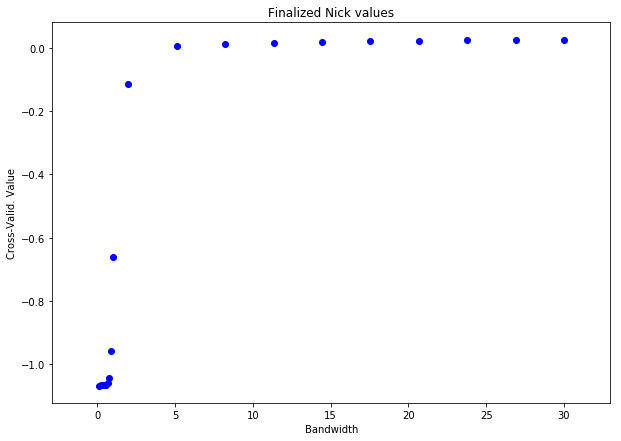

The max for the CV is found to be: 18 bin width


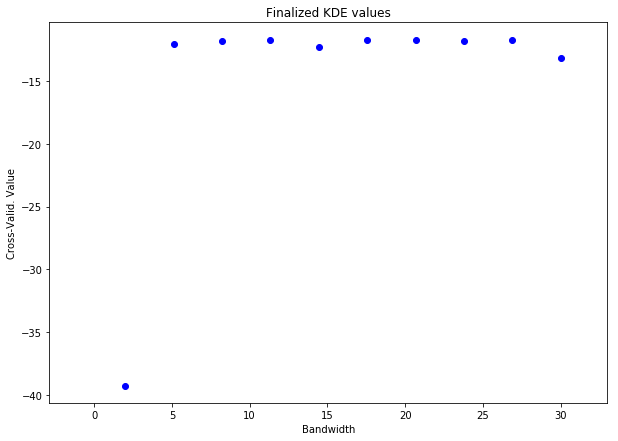

The max for the CV is found to be: 14 bin width


In [25]:
try:
    if finalnick:
        plt.clf()
        plt.figure(figsize=[10,7])
        plt.plot(bw_range,finalnick,'bo')
        bwranging=abs(min(bw_range)-max(bw_range))
        plt.xlim(min(bw_range)-bwranging/10.,max(bw_range)+bwranging/10.)
        plt.title("Finalized Nick values")
        plt.xlabel("Bandwidth")
        plt.ylabel("Cross-Valid. Value")
        plt.show()
        print("The max for the CV is found to be: {} bin width".format(finalnick.index(max(finalnick))))
except NameError:
    print("No data found for nick method")
try:
    if finals:
        plt.clf()
        plt.figure(figsize=[10,7])
        plt.plot(bw_range,finals,'bo')
        bwranging=abs(min(bw_range)-max(bw_range))
        plt.xlim(min(bw_range)-bwranging/10.,max(bw_range)+bwranging/10.)
        plt.title("Finalized KDE values")
        plt.xlabel("Bandwidth")
        plt.ylabel("Cross-Valid. Value")
        plt.show()
        print("The max for the CV is found to be: {} bin width".format(finals.index(max(finals))))
except NameError:
    print("No data found for KDE method")

### I don't really understand what the KDE is representing but whatever, it is included. It got the same results as I did so close enough

# I am going to have to start charging you for wear and tear on my computer #newTA#Trump>Alex
